The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


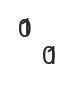

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [11]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


# def and checks

In [51]:
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df

In [79]:
summary_dfs_all = pd.read_csv('../output/cluster_analysis/summary_dfs_all.csv')
summary_dfs_top10 = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')

In [80]:
summary_dfs_all.head()

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
0,0,KLGGALQAK,19.512195,164,0,train,ClXaM,2.581458
1,1,KLGGALQAK,16.317992,239,0,train,ClXaM,3.762002
2,2,GILGFVFTL,27.391304,230,0,train,ClXaM,3.620337
3,3,AVFDRKSDAK,14.093960,149,0,train,ClXaM,2.345349
4,4,GILGFVFTL,16.528926,121,0,train,ClXaM,1.904612


In [109]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [111]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [110]:
summary_dfs_all.query('purity_percent>90')

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
1675,14,GILGFVFTL,100.000000,1,4,valid,B6jIc,0.015741
2005,6,IVTDFSVIK,92.592593,54,2,train,3jETu,0.849992
2109,6,IVTDFSVIK,94.736842,19,1,valid,LKzfT,0.299071
2226,19,IVTDFSVIK,93.750000,16,0,valid,x8CyX,0.251850
2733,6,KLGGALQAK,100.000000,1,0,valid,KtR1W,0.015741
2758,5,IVTDFSVIK,94.736842,19,1,valid,KtR1W,0.299071


In [90]:
summary_dfs_top10.query('set=="valid" and purity_percent>50 and cluster_size>12').groupby('run_id')\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,count
run_id,
KtR1W,5
NnzVv,5
x8CyX,5
3jETu,4
A0dGE,3


In [92]:
summary_dfs_all.query('set=="valid" and purity_percent>50 and cluster_size>10').groupby(['run_id', 'partition'])\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,,count
run_id,partition,
j0xLE,1,6
ClXaM,4,5
3jETu,4,4
LKzfT,3,4
KtR1W,2,3


In [86]:

summary_dfs_all.query('run_id=="KtR1W" and set=="valid"')

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
2727,0,IVTDFSVIK,19.230769,26,0,valid,KtR1W,0.409255
2728,1,RAKFKQLL,27.868852,61,0,valid,KtR1W,0.960176
2729,2,RAKFKQLL,27.118644,59,0,valid,KtR1W,0.928695
2730,3,KLGGALQAK,31.481481,54,0,valid,KtR1W,0.849992
2731,4,IVTDFSVIK,71.428571,21,0,valid,KtR1W,0.330552
...,...,...,...,...,...,...,...,...
2852,21,GILGFVFTL,16.666667,42,4,valid,KtR1W,0.661105
2853,22,ELAGIGILTV,21.212121,66,4,valid,KtR1W,1.038879
2854,23,KLGGALQAK,23.255814,43,4,valid,KtR1W,0.676846
2855,24,KLGGALQAK,26.530612,49,4,valid,KtR1W,0.771289


In [ ]:
summ

In [ ]:
addpep_dataset = CDR3BetaDataset(df, max_len=23, cdr3b_col='TRB_CDR3', add_pep=True, 

In [20]:
from src.models import PairedFVAE
model = PairedFVAE()

True

# TCR pepkernel similarity adj matrix

In [26]:
adj_matrix = pd.read_csv('../data/filtered/230929_nettcr_pos_adj_matrix.csv', index_col='A')
adj_matrix.head()

,CAAGDANTGELFF,CAAGGGGTEKLFF,CAAGQGNTGELFF,CAAGSSGNQPQHF,CAAGTRTDTQYF,CAAGTSGRVGEQFF,CAAGWGIGTEAFF,CAAQNGNPNEKLFF,CAASGRASETQYF,CACPPEEGGHYGYTF,...,CSVYLNTEAFF,CSYSAGEDQPQHF,CTSIAPIF,CTSKSGGPYEQF,CTSRDLGVWTEAF,CTSVPAAWDGASSYEQYF,CTSVPAVTVNFYGYTF,CTTSSGEADTQYF,CVPPYEKLTF,CVTGQGDINEQFF
A,,,,,,,,,,,,,,,,,,,,,
CAAGDANTGELFF,1.000000,0.833791,0.922672,0.808271,0.821413,0.832520,0.803848,0.805701,0.829519,0.698965,...,0.790501,0.772687,0.746653,0.785362,0.773166,0.716327,0.723947,0.820330,0.724117,0.820758
CAAGGGGTEKLFF,0.833791,1.000000,0.862865,0.797381,0.783272,0.818931,0.821764,0.771142,0.806494,0.682179,...,0.726746,0.737543,0.697982,0.788385,0.729241,0.676698,0.669484,0.771741,0.688156,0.780579
CAAGQGNTGELFF,0.922672,0.862865,1.000000,0.816436,0.808641,0.844086,0.814680,0.810145,0.820164,0.703386,...,0.772854,0.766710,0.725283,0.793320,0.756344,0.695332,0.705312,0.804836,0.710612,0.839774
CAAGSSGNQPQHF,0.808271,0.797381,0.816436,1.000000,0.800289,0.827664,0.754594,0.786589,0.836283,0.693642,...,0.733826,0.834720,0.713450,0.814682,0.726523,0.708205,0.680435,0.811575,0.698343,0.781084
CAAGTRTDTQYF,0.821413,0.783272,0.808641,0.800289,1.000000,0.819381,0.778730,0.758944,0.866828,0.677029,...,0.802260,0.779109,0.761954,0.786587,0.782478,0.706870,0.730053,0.848794,0.744953,0.794340


In [30]:
top10_pep = df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
top10_cdr3 = df.query('peptide in @top10_pep')['TRB_CDR3'].unique()
adj_top10 = adj_matrix.loc[top10_cdr3][top10_cdr3]

### spectral

In [32]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(26, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc = sc.fit_predict(adj_matrix)
sc = SpectralClustering(10, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc_top10 = sc.fit_predict(adj_top10)

In [59]:
sc_df = pd.DataFrame(np.array([adj_matrix.index, labels_sc]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df = pd.merge(df, sc_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary, sc_cluster_df = get_cluster_stats(sc_df, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

sc_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_sc_top10]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df_top10 = pd.merge(df, sc_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary_top10, sc_cluster_df_top10 = get_cluster_stats(sc_df_top10, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

### k-means

In [39]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import KMeans
km = KMeans(26, n_init=50, max_iter=500)
labels_km = km.fit_predict(adj_matrix)
km = KMeans(10, n_init=50, max_iter=500)
labels_km_top10 = km.fit_predict(adj_top10)

In [60]:
km_df = pd.DataFrame(np.array([adj_matrix.index, labels_km]).T, columns = ['TRB_CDR3', 'km_label'])
km_df = pd.merge(df, km_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary, km_cluster_df = get_cluster_stats(km_df, cluster='km_label', label='peptide', feature = 'B3', kf=False)

km_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_km_top10]).T, columns = ['TRB_CDR3', 'km_label'])
km_df_top10 = pd.merge(df, km_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary_top10, km_cluster_df_top10 = get_cluster_stats(km_df_top10, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [62]:
display(sc_summary_top10)
display(km_summary_top10)

,sc_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,25.986842,608,ALL,11.215643
1,1,GILGFVFTL,26.682692,416,ALL,7.673861
2,2,KLGGALQAK,23.750000,480,ALL,8.854455
3,3,IVTDFSVIK,17.325800,531,ALL,9.795241
4,4,GILGFVFTL,35.205479,730,ALL,13.466150
5,5,RAKFKQLL,31.319555,629,ALL,11.603025
6,6,RAKFKQLL,21.386139,505,ALL,9.315624
7,7,GILGFVFTL,19.646799,453,ALL,8.356392
8,8,KLGGALQAK,20.000000,510,ALL,9.407858
9,9,RAKFKQLL,19.499106,559,ALL,10.311751


,km_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,23.869347,398,ALL,7.341819
1,1,RAKFKQLL,18.454936,466,ALL,8.596200
2,2,GILGFVFTL,33.050847,708,ALL,13.060321
3,3,RAKFKQLL,25.901639,915,ALL,16.878805
4,4,GILGFVFTL,43.193069,808,ALL,14.904999
5,5,AVFDRKSDAK,23.863636,88,ALL,1.623317
6,6,IVTDFSVIK,18.620690,435,ALL,8.024350
7,7,KLGGALQAK,20.033389,599,ALL,11.049622
8,8,KLGGALQAK,20.309051,453,ALL,8.356392
9,9,KLGGALQAK,17.967332,551,ALL,10.164176


# Meta analysis
Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

-  Note to self: KtR1W says it has add_pep but I'm 98% sure that add_pep had not been done correctly (I spent all morning of wednesday 231004 to fix it) so this is just 25k epochs of CDR3b.
-  Re-ran two scripts : AddPep 25K epochs, wd=1e-4 (ID = 4soiY) and Normal CDR3b 30k epochs, wd=1e-4 (ID = EDHpH)
-  FOR THE ANALYSIS: TAKE ONLY NnzVv just to check stuff --> Take fold that is stable, compare test and train latent for GILGFVCTL (pos and true negs)

In [134]:
summary_dfs_top10.query('run_id=="NnzVv"').sort_values('purity_percent', ascending=False).head(25)

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
113,3,GILGFVFTL,79.032258,124,1,valid,NnzVv,2.292899
320,0,GILGFVFTL,73.265306,490,2,train,NnzVv,9.060651
120,0,GILGFVFTL,72.222222,126,2,valid,NnzVv,2.329882
313,3,GILGFVFTL,67.315175,514,1,train,NnzVv,9.504438
133,3,GILGFVFTL,62.500000,88,3,valid,NnzVv,1.627219
338,8,GILGFVFTL,56.989247,372,3,train,NnzVv,6.878698
344,4,GILGFVFTL,56.325823,577,4,train,NnzVv,10.669379
144,4,GILGFVFTL,55.639098,133,4,valid,NnzVv,2.459320
333,3,GILGFVFTL,52.769679,343,3,train,NnzVv,6.342456
138,8,GILGFVFTL,51.111111,90,3,valid,NnzVv,1.664201


In [179]:
folder30k = '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/'
subfolders30k = sorted([f'{folder30k}{x}' for x in os.listdir(folder30k) if os.path.isdir(f'{folder30k}{x}') and 'store' not in x.lower()])
subfolders30k

['../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_0_231004_1726_EDHpH',
 '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_1_231004_1726_EDHpH',
 '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_2_231004_1756_EDHpH',
 '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_3_231004_1756_EDHpH',
 '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_4_231004_1756_EDHpH']

In [181]:
folder10k = '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/'
subfolders10k = sorted([f'{folder10k}{x}' for x in os.listdir(folder10k) if os.path.isdir(f'{folder10k}{x}') and 'store' not in x.lower()])
subfolders10k

['../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_0_230928_1820_NnzVv',
 '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_1_230928_1820_NnzVv',
 '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_2_230928_1820_NnzVv',
 '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_3_230928_1820_NnzVv',
 '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_4_230928_1820_NnzVv']

In [247]:
ntcr = pd.read_csv('../data/NetTCR/new_train_df.csv')
ntcr = ntcr.drop(columns=['Unnamed: 0']).query('origin != "swapped"')
ntcr.to_csv('../data/filtered/231005_nettcr_pos_truenegs.csv', index=False)

In [268]:
# Just take fold == 2 and do something here...
from torch.utils.data import SequentialSampler
from src.torch_utils import load_checkpoint
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset

max_len, encoding, pad_scale, aa_dim = 25, 'BL50LO', -20, 20
hidden_dim, latent_dim = 128, 64
use_v, use_j = False,  False
fold=2
train = df.query('partition!=@fold')
train_dataset = CDR3BetaDataset(train, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
train_loader = train_dataset.get_dataloader(1024, SequentialSampler)
valid = df.query('partition==@fold')
valid_dataset = CDR3BetaDataset(valid, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
valid_loader = valid_dataset.get_dataloader(1024, SequentialSampler)
# take this as the "test set"
gil_testdf = ntcr.query('peptide=="GILGFVFTL" and CDR3b not in @train_preds_30k.TRB_CDR3.unique()')
gil_dataset = CDR3BetaDataset(gil_testdf, max_len, encoding, pad_scale, 'CDR3b', use_v, use_j)
gil_loader = gil_dataset.get_dataloader(1024, SequentialSampler)

In [269]:
# reloading models
print('30k')
model = CDR3bVAE(max_len, encoding, pad_scale, aa_dim, use_v, use_j, hidden_dim=hidden_dim, latent_dim=latent_dim)
model_30k = load_checkpoint(model, f'{subfolders30k[fold]}/checkpoint_best_fold{fold:02}_kcv_230927_nettcr_positives_only_f{fold:02}_30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_{fold}_231004_1756_EDHpH.pt')

print('\n10k')
model = CDR3bVAE(max_len, encoding, pad_scale, aa_dim, use_v, use_j, hidden_dim=hidden_dim, latent_dim=latent_dim)
model_10k = load_checkpoint(model, f'{subfolders10k[fold]}/checkpoint_best_fold{fold:02}_kcv_230927_nettcr_positives_only_f{fold:02}_10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_{fold}_230928_1820_NnzVv.pt')

30k
25
Reloading best model:
Best epoch: 26660
Valid loss: {'total': 0.14889138590239878, 'reconstruction': 0.08501176325217732, 'kld': 0.06387961965124563}
total: 0.14889138590239878
reconstruction: 0.08501176325217732
kld: 0.06387961965124563
seq_accuracy: 0.9841359257698059
v_accuracy: 0
j_accuracy: 0

10k
25
Reloading best model:
Best epoch: 9740
Valid loss: {'total': 0.1681371012573722, 'reconstruction': 0.10062906755216466, 'kld': 0.06750803370520754}
total: 0.1681371012573722
reconstruction: 0.10062906755216466
kld: 0.06750803370520754
seq_accuracy: 0.9800545573234558
v_accuracy: 0
j_accuracy: 0


In [278]:
def plot_latent(df, cols, hue):
    vars_ = cols
    print(f'VAE latent space representation for {cols[0]}-{cols[-1]}')
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle(f'VAE latent space representation for {cols[0]}-{cols[-1]}', fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot,  alpha=0.75)
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    f.tight_layout()
    plt.show()

In [271]:
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model
train_preds_30k = predict_model(model_30k, train_dataset, train_loader)
valid_preds_30k = predict_model(model_30k, valid_dataset, valid_loader)
gil_preds_30k = predict_model(model_30k, gil_dataset, gil_loader)

z_train_30k = train_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_train_30k = train_preds_30k['peptide'].values
z_valid_30k = valid_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_valid_30k = valid_preds_30k['peptide'].values

z_gil_30k = gil_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_gil_30k = gil_preds_30k['peptide'].values

In [317]:
os.makedirs('../data/preds_30k/',exist_ok=True)
train_preds_30k.to_csv('../data/preds_30k/train_preds_30k.csv', index=False)
valid_preds_30k.to_csv('../data/preds_30k/valid_preds_30k.csv', index=False)
gil_preds_30k.to_csv('../data/preds_30k/gil_preds_30k.csv', index=False)

In [ ]:
z_train_30k = train_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_train_30k = train_preds_30k['peptide'].values
z_valid_30k = valid_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_valid_30k = valid_preds_30k['peptide'].values

z_gil_30k = gil_preds_30k[[f'z_{i}' for i in range(latent_dim)]].values
labels_gil_30k = gil_preds_30k['peptide'].values

VAE latent space representation for z_0-z_4


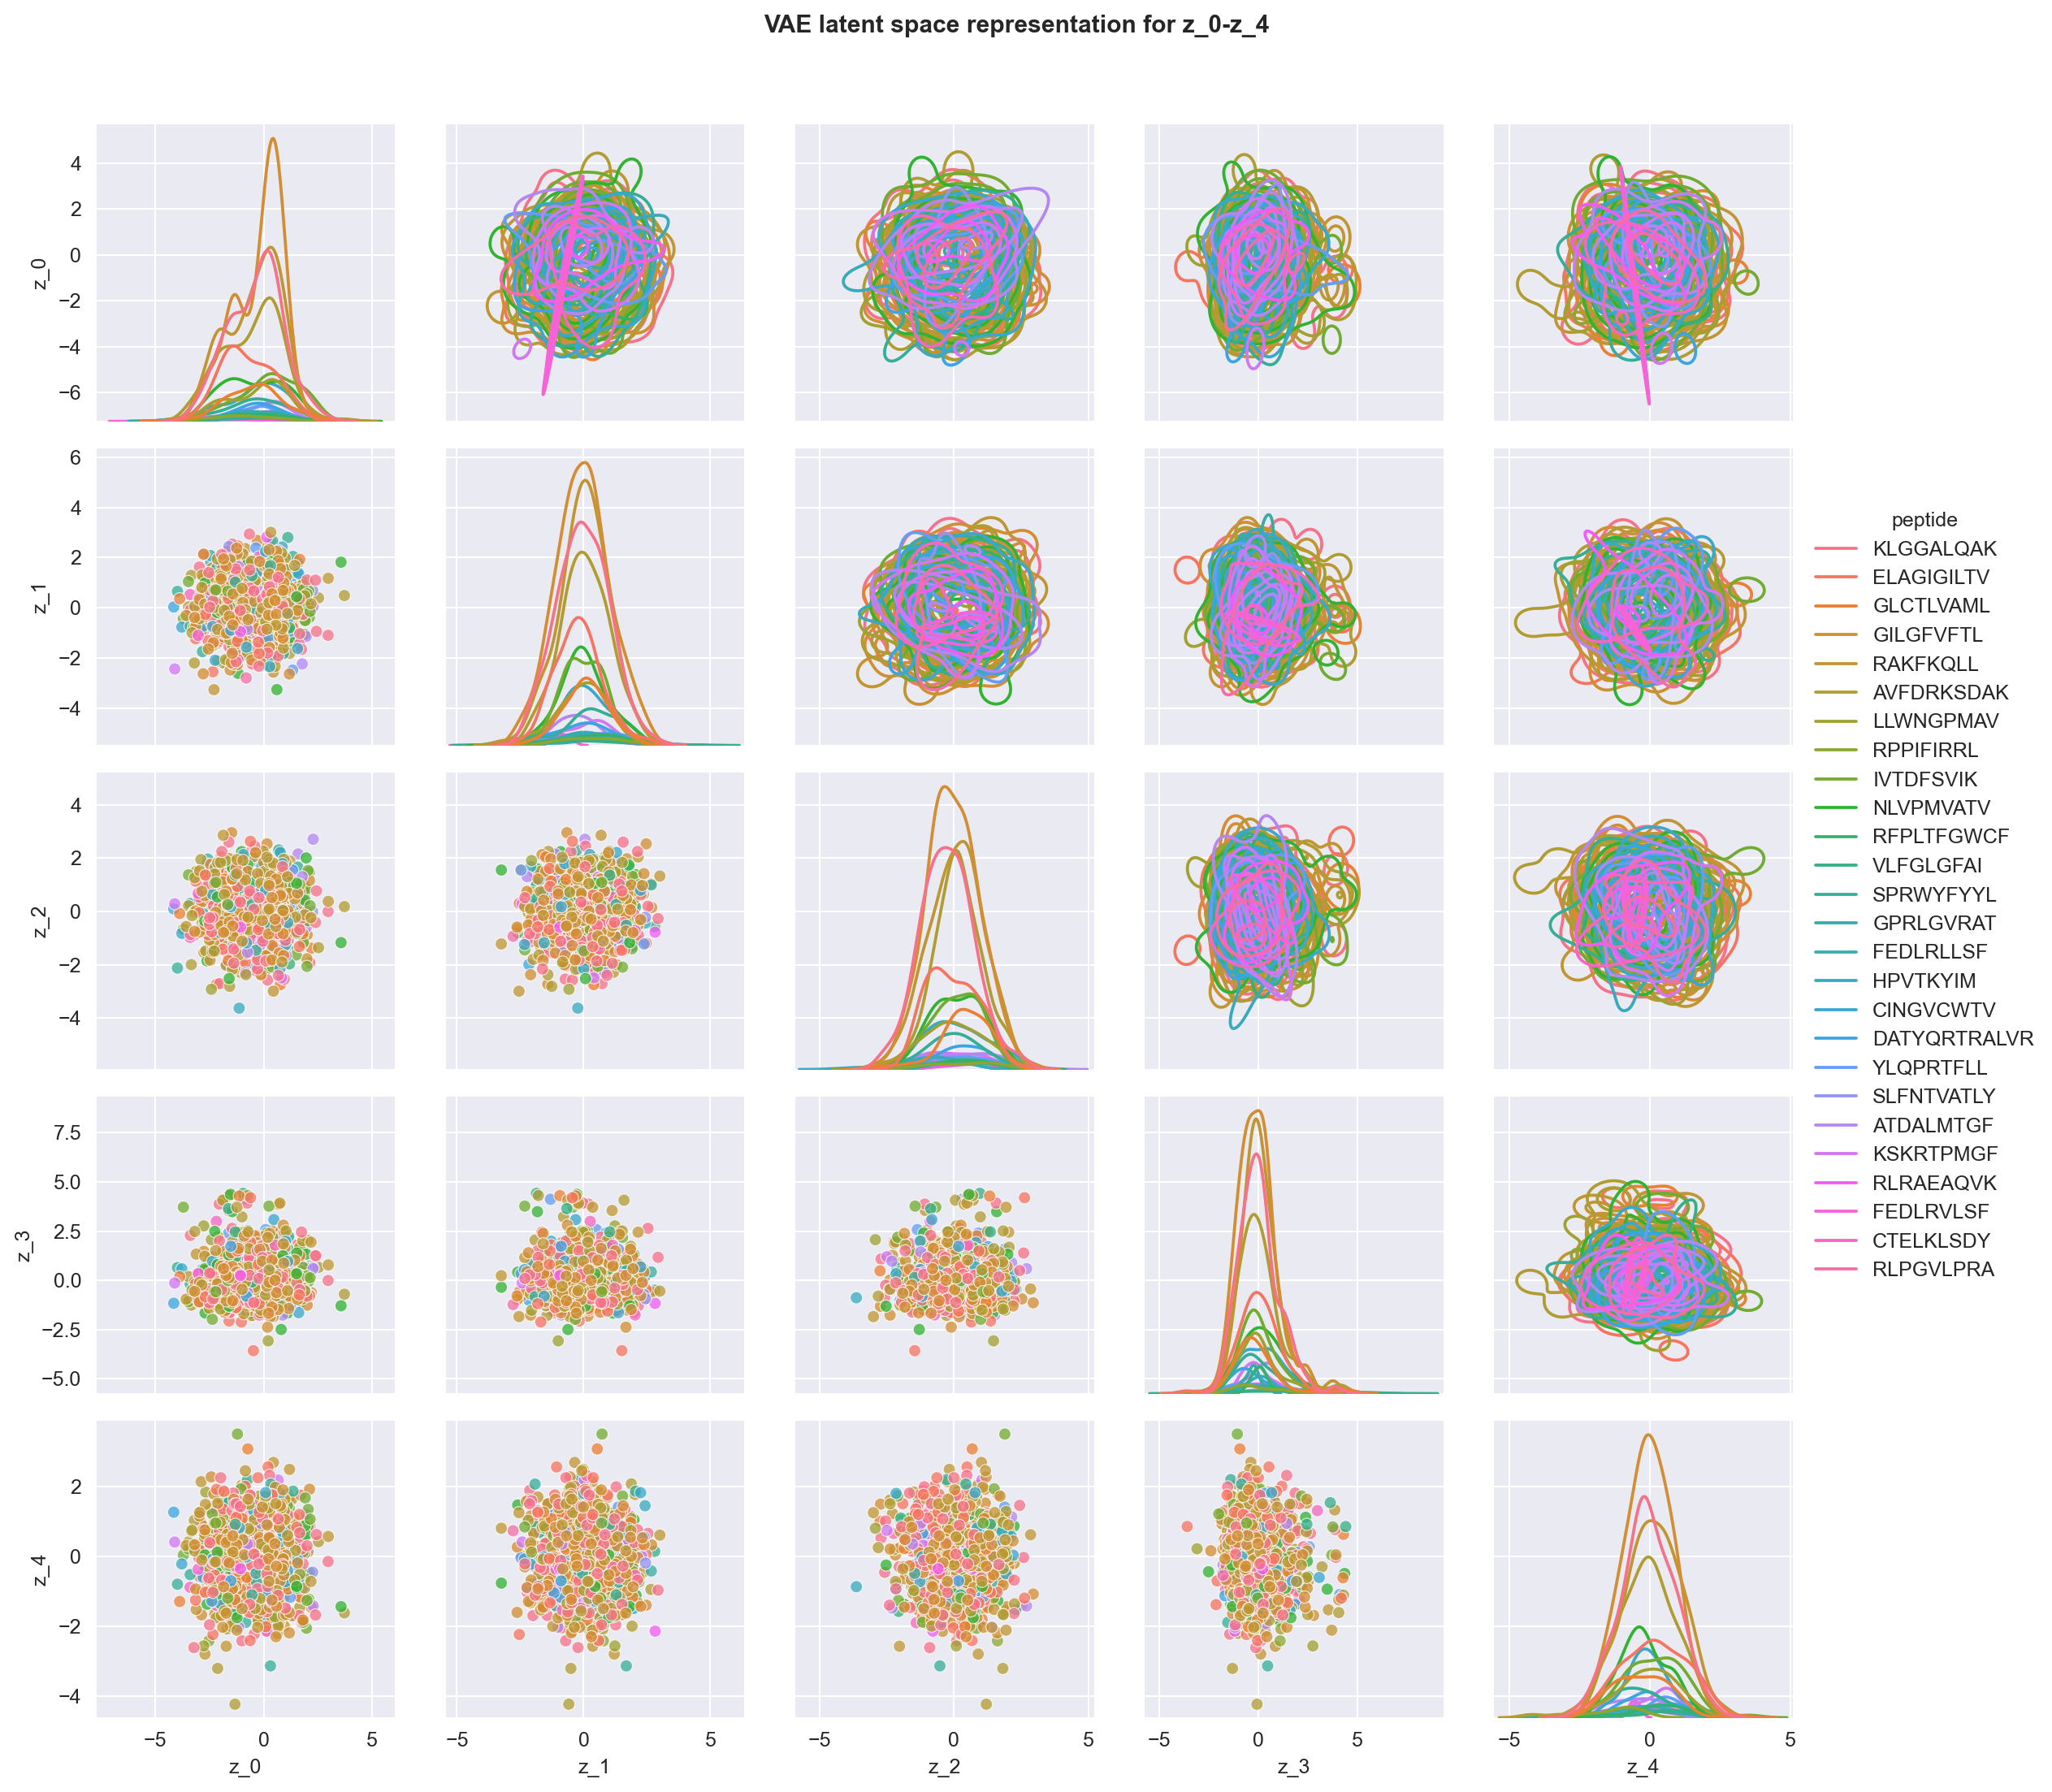

In [279]:
plot_latent(valid_preds_30k, [f'z_{i}' for i in range(5)], 'peptide')

In [152]:
[x for x in sklearn.cluster.__all__ if any([z.isupper() for z in x])]

['AffinityPropagation',
 'AgglomerativeClustering',
 'Birch',
 'DBSCAN',
 'OPTICS',
 'KMeans',
 'BisectingKMeans',
 'FeatureAgglomeration',
 'MeanShift',
 'MiniBatchKMeans',
 'SpectralClustering',
 'SpectralBiclustering',
 'SpectralCoclustering',
 'HDBSCAN']

In [282]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

In [286]:
pairwise_kernels??

Signature:
pairwise_kernels(
    X,
    Y=None,
    metric='linear',
    *,
    filter_params=False,
    n_jobs=None,
    **kwds,
)
Source:   
def pairwise_kernels(
    X, Y=None, metric="linear", *, filter_params=False, n_jobs=None, **kwds
):
    """Compute the kernel between arrays X and optional array Y.

    This method takes either a vector array or a kernel matrix, and returns
    a kernel matrix. If the input is a vector array, the kernels are
    computed. If the input is a kernel matrix, it is returned instead.

    This method provides a safe way to take a kernel matrix as input, while
    preserving compatibility with many other algorithms that take a vector
    array.

    If Y is given (default is None), then the returned matrix is the pairwise
    kernel between the arrays from both X and Y.

    Valid values for metric are:
        ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf',
        'laplacian', 'sigmoid', 'cosine']

    Read more in the :ref:`User G

In [285]:
pairwise_distances??

Signature:
pairwise_distances(
    X,
    Y=None,
    metric='euclidean',
    *,
    n_jobs=None,
    force_all_finite=True,
    **kwds,
)
Source:   
def pairwise_distances(
    X, Y=None, metric="euclidean", *, n_jobs=None, force_all_finite=True, **kwds
):
    """Compute the distance matrix from a vector array X and optional Y.

    This method takes either a vector array or a distance matrix, and returns
    a distance matrix. If the input is a vector array, the distances are
    computed. If the input is a distances matrix, it is returned instead.

    This method provides a safe way to take a distance matrix as input, while
    preserving compatibility with many other algorithms that take a vector
    array.

    If Y is given (default is None), then the returned matrix is the pairwise
    distance between the arrays from both X and Y.

    Valid values for metric are:

    - From scikit-learn: ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
      'manhattan']. These metrics suppo

In [287]:
km = KMeans(2, n_init=1, max_iter=10, random_state=13)
train_clusters = km.fit_predict(z_train_30k)
valid_clusters = km.predict(z_valid_30k)
gil_clusters = km.predict(z_gil_30k)

In [294]:
DISTANCES=['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan','braycurtis', 'canberra', 'chebyshev', 'correlation', 
 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 
 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
KERNELS = ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']

In [295]:
%mkdir ../output/bruteforce_clustering/

In [298]:
train_preds_30k.columns.join(gil_preds_30k.columns,how='inner')

Index(['A1', 'A2', 'B1', 'B2', 'binder', 'peptide', 'partition', 'allele',
       'origin', 'len', 'seq_acc', 'hat_reconstructed', 'true_reconstructed',
       'n_errors_seq', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'z_16',
       'z_17', 'z_18', 'z_19', 'z_20', 'z_21', 'z_22', 'z_23', 'z_24', 'z_25',
       'z_26', 'z_27', 'z_28', 'z_29', 'z_30', 'z_31', 'z_32', 'z_33', 'z_34',
       'z_35', 'z_36', 'z_37', 'z_38', 'z_39', 'z_40', 'z_41', 'z_42', 'z_43',
       'z_44', 'z_45', 'z_46', 'z_47', 'z_48', 'z_49', 'z_50', 'z_51', 'z_52',
       'z_53', 'z_54', 'z_55', 'z_56', 'z_57', 'z_58', 'z_59', 'z_60', 'z_61',
       'z_62', 'z_63'],
      dtype='object')

In [314]:
from joblib import Parallel, delayed
from functools import partial
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df
        
def bruteforce(n_clusters, ODIR):
    km = KMeans(n_clusters, n_init=100, max_iter=500, random_state=13)
    train_clusters = km.fit_predict(z_train_30k)
    valid_clusters = km.predict(z_valid_30k)
    gil_clusters = km.predict(z_gil_30k)
    name = f'KM_n{n_clusters:02}'
    train_preds_30k[name] = train_clusters
    valid_preds_30k[name] = valid_clusters
    gil_preds_30k[name] = gil_clusters
    train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
    valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
    gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
    train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
    train_df.to_csv(f'{ODIR}train_df_{name}.csv')
    valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
    valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
    gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
    gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')
    
    for kernel in tqdm(['rbf', 'laplacian', 'cosine'], desc='sc kernel', position=1, leave=False):
        sc = SpectralClustering(n_clusters, affinity=kernel, n_init=30, random_state=13,n_jobs=1)
        clusters = sc.fit_predict(np.concatenate([z_train_30k, z_valid_30k, z_gil_30k], axis=0))
        train_clusters = clusters[:len(z_train_30k)]
        valid_clusters = clusters[len(z_train_30k): len(z_train_30k)+len(z_valid_30k)]
        gil_clusters = clusters[len(z_train_30k)+len(z_valid_30k):]
        name = f'SC_{kernel}_n{n_clusters:02}'
        train_preds_30k[name] = train_clusters
        valid_preds_30k[name] = valid_clusters
        gil_preds_30k[name] = gil_clusters
        train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
        valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
        gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
        train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
        train_df.to_csv(f'{ODIR}train_df_{name}.csv')
        valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
        valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
        gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
        gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')

In [ ]:
from datetime import datetime as dt
start = dt.now()
n_clusters = 10
kernel = 'laplacian'
sc = SpectralClustering(n_clusters, affinity=kernel, n_init=30, random_state=13, n_jobs=None, verbose=1)
clusters = sc.fit_predict(np.concatenate([z_train_30k, z_valid_30k, z_gil_30k], axis=0))
train_clusters = clusters[:len(z_train_30k)]
valid_clusters = clusters[len(z_train_30k): len(z_train_30k)+len(z_valid_30k)]
gil_clusters = clusters[len(z_train_30k)+len(z_valid_30k):]
end = dt.now()
elapsed = divmod((end - start).seconds, 60)
print(f'Program finished in {elapsed[0]} minutes, {elapsed[1]} seconds.')

In [316]:
train_preds_30k = pd.read_csv('../data/preds_30k/train_preds_30k.csv')
valid_preds_30k = pd.read_csv('../data/preds_30k/valid_preds_30k.csv')
gil_preds_30k = pd.read_csv('../data/preds_30k/gil_preds_30k.csv')
ODIR='../output/bruteforce_clustering/'
ntm = partial(bruteforce, ODIR=ODIR)
Parallel(n_jobs=30)(delayed(ntm)(n_clusters=n_clusters) for n_clusters in tqdm(range(2, 50), desc='n_clst', position=0, leave=True))

    

sc kernel:   0%|          | 0/3 [00:00<?, ?it/s]

                                                
                                                
                                                
                                                
                                                

KeyboardInterrupt: 